# Example 1: Two plants, constant supply curves
_______

This illustrates storage impact in a 2 power plant/2 time slot system with constant supply curves.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import symenergy.core.model as model
import symenergy.evaluator.evaluator as evaluator

pd.options.mode.chained_assignment = None

## Initialize model
The model structure is initialized.

Parameter values are insignificant at this stage as long as they are !=None. They represent default values and define the model structure.

`Model.generate_solve()` loads the solved model results from the corresponding pickle file if a model with the same structure (variables and multipliers) has been solved before.

`nthread` is the number of cores used for parallelized solving.

In [3]:
m = model.Model(curtailment=True, nthreads=7)

m.add_slot(name='day', load=4.5, vre=3)
m.add_slot(name='night', load=5, vre=0.5)

m.add_plant(name='n', vc0=1, vc1=None, slots=m.slots, capacity=3, fcom=10, cap_ret=True)
m.add_plant(name='g', vc0=2, vc1=None, slots=m.slots)

m.add_storage(name='phs', eff=0.75, slots=m.slots,
              capacity=0.5, energy_capacity=1,
              slots_map={'day': 'chg', 'night': 'dch'})

m.generate_solve()


Loading from pickle file /mnt/data/Dropbox/SHARED_REPOS/symenergy/cache/C04F76D522DF.pickle.


## Initialize evaluator instance, set model parameters and parameter sweep values.
The model results are evaluated for all combinations of the iterables' values in the `x_vals` argument.

The `Evaluator.df_x_vals` instance attribute is modified after initialization to
* filter model runs
* set the storage energy capacity `E_phs` in dependence on the efficiency `eff_phs` (i.e. the storage type)

In [4]:
m.comps['n'].vc0.value = 10
m.comps['n'].fcom.value = 9
m.comps['n'].C.value = 3500

m.comps['g'].vc0.value = 90

m.slots['day'].l.value = 6500
m.slots['night'].l.value = 5200

vre_day = 1
vre_night = 0.1
tot_l = m.slots['day'].l.value + m.slots['night'].l.value

m.slots['day'].vre.value = vre_day / (vre_day + vre_night) * tot_l
m.slots['night'].vre.value = vre_night / (vre_day + vre_night) * tot_l

m.storages['phs'].eff.value = 0.75
m.storages['phs'].C.value = 1
m.storages['phs'].E.value = 1

dd_75 = 14
dd_90 = 4

phs_C_max = m.slots['day'].l.value * 0.5

x_vals_vre = {m.vre_scale: np.linspace(0, 1, 21),
              m.comps['phs'].C: [0, 2600],
              m.comps['phs'].E: [None], # <-- set later
              m.comps['phs'].eff: [0.75, 0.9],
              m.comps['n'].C: [2000, 4000, 5000],
              }

ev = evaluator.Evaluator(m, x_vals_vre, drop_non_optimum=False)

ev.df_x_vals['E_phs'] = ev.df_x_vals.C_phs
ev.df_x_vals.loc[ev.df_x_vals.eff_phs == 0.90, 'E_phs'] *= dd_90/12
ev.df_x_vals.loc[ev.df_x_vals.eff_phs == 0.75, 'E_phs'] *= dd_75/12

mask_vre = (ev.df_x_vals.vre_scale.isin(np.linspace(0, 1, 11))
            | ev.df_x_vals.vre_scale.isin(np.linspace(0.55, 0.75, 21)))
mask_phs = (ev.df_x_vals.C_phs.isin(np.linspace(0, phs_C_max, 6)))

ev.df_x_vals = ev.df_x_vals.loc[mask_vre | mask_phs]

print(ev.df_x_vals.head(10))
print('Length: ', len(ev.df_x_vals))

   vre_scale  C_phs        E_phs  eff_phs   C_n
0        0.0      0     0.000000     0.75  2000
1        0.0      0     0.000000     0.75  4000
2        0.0      0     0.000000     0.75  5000
3        0.0      0     0.000000     0.90  2000
4        0.0      0     0.000000     0.90  4000
5        0.0      0     0.000000     0.90  5000
6        0.0   2600  3033.333333     0.75  2000
7        0.0   2600  3033.333333     0.75  4000
8        0.0   2600  3033.333333     0.75  5000
9        0.0   2600   866.666667     0.90  2000
Length:  252


## Generate functions from the symenergy results
This evaluates the results using the fixed parameters and returns functions with arguments corresponding to the columns in the `Evaluator.df_x_vals` table 

In [5]:
ev.get_evaluated_lambdas(skip_multipliers=True)

Extracting solution for n_C_ret_None...substituting...lambdify...done.
Extracting solution for n_p_day...substituting...lambdify...done.
Extracting solution for n_p_night...substituting...lambdify...done.
Extracting solution for g_p_day...substituting...lambdify...done.
Extracting solution for g_p_night...substituting...lambdify...done.
Extracting solution for phs_e_None...substituting...lambdify...done.
Extracting solution for phs_p_day...substituting...lambdify...done.
Extracting solution for phs_p_night...substituting...lambdify...done.
Extracting solution for curt_p_day...substituting...lambdify...done.
Extracting solution for curt_p_night...substituting...lambdify...done.
Extracting solution for pi_load_day...substituting...lambdify...done.
Extracting solution for pi_load_night...substituting...lambdify...done.
Extracting solution for tc...substituting...lambdify...done.


## Evaluate results for all entries of the `Evaluator.df_x_vals table`
**Note: Depending on the size of the model and the `df_x_vals` table this takes a while.**

In [6]:
ev.expand_to_x_vals(verbose=False)

## Add additional columns to the `Evaluator.df_exp` table
Variables are not indexed by time slot names. The `Evaluator.map_func_to_slot` method expands the `Evaluator.df_exp` table by additional columns with variable names and time slots names.

In [7]:
ev.map_func_to_slot()

map_func_to_slot


## Build supply table `Evaluator.df_bal`
This includes the demand to the result demand and adjusts the signs, such that demand, charging, and curtailment are negative. 


In [8]:
ev.build_supply_table()

print(ev.df_bal.head(5))

         C_n  C_phs  E_phs                                         const_comb  \
1196  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
1197  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
1198  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
1199  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
1200  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   

      eff_phs                   func func_no_slot   lambd    slot  vre_scale  
1196     0.75  n_C_ret_None_lam_plot      n_C_ret     0.0  global        0.0  
1197     0.75       n_p_day_lam_plot          n_p  2000.0     day        0.0  
1198     0.75     n_p_night_lam_plot          n_p  2000.0   night        0.0  
1199     0.75       g_p_day_lam_plot          g_p  4500.0     day        0.0  
1200     0.75     g_p_night_lam_plot          g_p  3200.0   night        0.0  


## Simple energy balance plot with and without storage for day and night


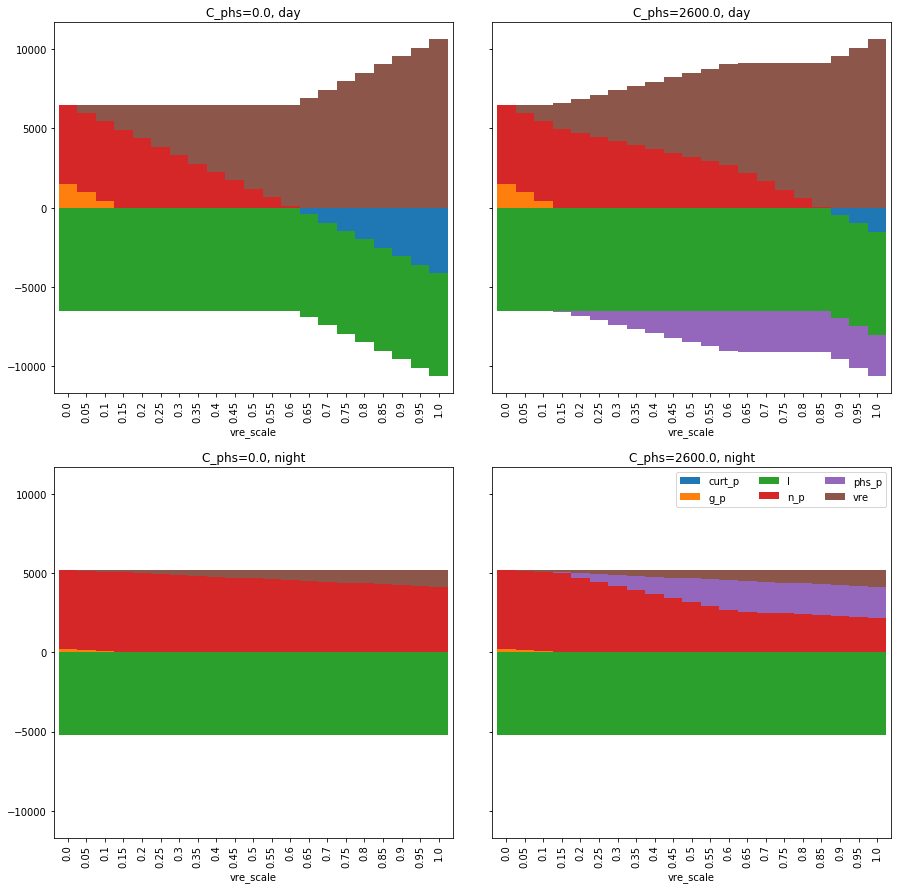

In [9]:
df = ev.df_bal
df = df.loc[-df.func_no_slot.str.contains('tc', 'lam')
           & df.eff_phs.isin([0.75])
           & df.C_n.isin([5000])
           & -df.slot.isin(['global'])]

df['lambd'] = df.lambd.astype(float)
df['vre_scale'] = df.vre_scale.apply(lambda x: round(x*10000)/10000)


dfpv = df.pivot_table(columns='func_no_slot', values='lambd', index=['C_phs', 'slot', 'vre_scale'])

list_slot = dfpv.index.get_level_values('slot').unique()
list_c_phs = dfpv.index.get_level_values('C_phs').unique()

fig, axarr = plt.subplots(len(list_c_phs),
                          len(list_slot), sharey=True, gridspec_kw={'wspace': 0.1,}, figsize=(15,15))

for nslot, slot in enumerate(list_slot):
    for nc_phs, c_phs in enumerate(list_c_phs):

        ax = axarr[nslot][nc_phs]
        dfpv.loc[(c_phs, slot)].plot.bar(ax=ax, legend=False, use_index=True, stacked=True, width=1)
        
        ax.set_title('C_phs=%s, %s'%(c_phs, slot))

        
leg = ax.legend(ncol=3)        



## Impact of storage on baseload production by constraint combination

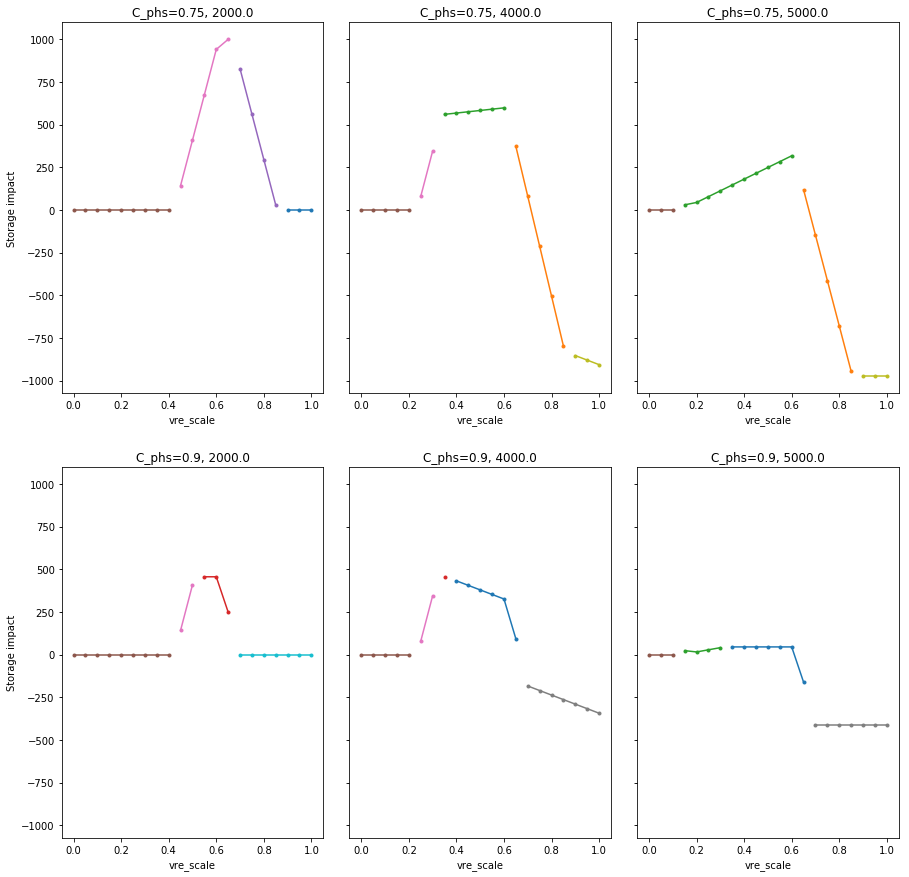

In [10]:
df = ev.df_exp
df = df.loc[df.func.str.contains('n_p_')
           & df.is_optimum.isin([True])
           & -df.slot.isin(['global'])]

df.head(5)

dfdiff = df.pivot_table(index=[x for x in ev.x_name if not x in ['E_phs', 'C_phs']] + ['func'],
                        values='lambd', columns='C_phs')
dfdiff['diff'] = dfdiff[2600] - dfdiff[0]

dfcc = df.loc[df.C_phs == 2600].set_index(dfdiff.index.names)['const_comb']
dfdiff = dfdiff.reset_index().join(dfcc, on=dfdiff.index.names)

dfpv = dfdiff.pivot_table(index=['eff_phs', 'C_n', 'vre_scale'], columns='const_comb', values='diff')

list_eff = dfpv.index.get_level_values('eff_phs').unique()
list_c_n = dfpv.index.get_level_values('C_n').unique()

fig, axarr = plt.subplots(len(list_eff),
                          len(list_c_n), sharey=True, gridspec_kw={'wspace': 0.1,}, figsize=(15,15))

for neff, eff in enumerate(list_eff):
    for nc_n, c_n in enumerate(list_c_n):

        ax = axarr[neff][nc_n] if isinstance(axarr, np.ndarray) else axarr
        dfpv.loc[(eff, c_n)].plot(ax=ax, legend=False, marker='.',use_index=True, stacked=False, width=1)
        
        ax.set_title('C_phs=%s, %s'%(eff, c_n))
        ax.set_ylabel('Storage impact')